# TP Programming with Keras - Density Neural Network

We will build a Density Neural Network in order to make uncertainty prediction in a regression case.

In this practice session, some cells must be filled according to the instructions. They are identified by the word **Exercise**. You will perform the **Verifications** yourselves in most cases, by watching if the algorithm correctly works and converges.

Below we import the required libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf

: 

## Data definition

In order to easily visualize the data, we will use 1D data (as input and output): a cosinus with a gaussian noise. The following cell builds the data.

In [2]:
#DO NOT CHANGE
N_train = 1000

X_train = np.random.rand(N_train)*8 - 4

sigma = np.abs(np.cos(X_train))*0.2

Y_train = np.cos(X_train) + np.random.normal(0, sigma)

N_test = 1000

X_test = np.linspace(-8,8,N_test)

Y_test = np.cos(X_test)

X_train = np.reshape(X_train,(X_train.shape[0],1))

Y_train = np.reshape(Y_train,(Y_train.shape[0],1))

**Exercise**: Plot the training data by using a scatter plot.

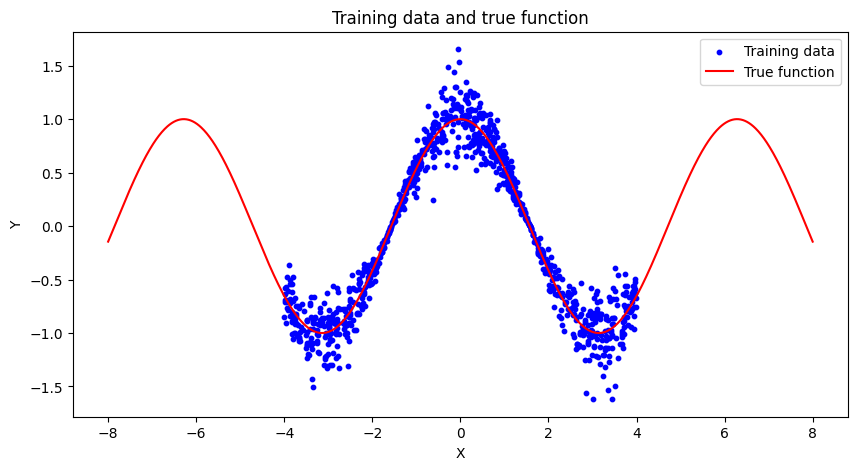

In [3]:
#TO DO
plt.figure(figsize=(10,5))
plt.scatter(X_train,Y_train,label='Training data',color='blue',s=10)
plt.plot(X_test,Y_test,label='True function',color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Training data and true function')
plt.legend()
plt.show()

## Creation of a density layer and the associated loss function

We will assume that the output follows a probability density $p(y|x)$ from a normal distribution with mean $\mu$ and standard deviation $\sigma$. We aim to predict both parameters $\mu$ and $\sigma$. To do so, we create a custom layer, adapted to this problem.

In the following cell, we create a new class DenseNormal which takes as argument the number $N$ of desired neurons and outputs $2N$ values: each neuron consists in one value of $\mu$ and $\sigma$.

**Exercise**: $\sigma$ must be strictly positive. To do so, apply the function tf.nn.softplus to logsigma. Moreover add a small $\varepsilon$ to avoid divergence problems during the training (we avoid $\sigma$ being too close to 0). 1e-6 should be enough.

In [5]:
class DenseNormal(keras.layers.Layer):
    def __init__(self, units):
        super(DenseNormal, self).__init__()
        self.units = int(units)
        self.dense = keras.layers.Dense(2 * self.units)

    def call(self, x):
        output = self.dense(x)
        mu, logsigma = tf.split(output, 2, axis=-1)
        sigma = tf.nn.softplus(logsigma) + 1e-6
        return tf.concat([mu, sigma], axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 2 * self.units)

    def get_config(self):
        base_config = super(DenseNormal, self).get_config()
        base_config['units'] = self.units
        return base_config

We now created a custom loss-function. We recall the likelihood of the gaussian distribution:

\begin{equation}
p(y|\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma} e^{-\frac{(y-\mu)^2}{2\sigma^2}}
\end{equation}

The associated log-likelihood is given by:

\begin{equation}
\log(p(y|\mu,\sigma)) = -\log(\sqrt{2\pi}\sigma) -\left (\frac{y-\mu}{\sqrt{2\pi}\sigma}\right)^2
\end{equation}

**Exercise**: Complete the following code by giving the full log-likelihood formula.

In [135]:
def Gaussian_NLL(y, net_output, reduce=True):
    mu, sigma = tf.split(net_output, 2, axis=-1)
    ax = list(range(1, len(y.shape)))

    logprob = - tf.math.log( tf.sqrt(2. * np.pi) * sigma ) - 0.5* tf.math.square((y - mu)) / tf.square( sigma)
    loss = tf.reduce_mean(-logprob, axis=ax)
    return tf.reduce_mean(loss) if reduce else loss

## Keras model

### Model creation

**Exercise**: Create a Keras model, with name "my_model". Use only Dense layer. The last layer will be a DenseNormal layer (previously created class), with only one neuron since the output is 1 dimensional.

In [136]:
#TO DO

model = keras.Sequential()

model.add(keras.layers.Input(shape=(1,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(DenseNormal(1))


**Exercise**: Display your architecture by calling my_model.summary()

In [137]:
#TO DO
model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_61 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_normal_29 (DenseNormal)   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,418 (17.26 KB)

 Trainable params: 4,418 (17.26 KB)

 Non-trainable params: 0 (0.00 B)

### Model compilation

**Exercise**: You must compile the model by defining an optimizer and a loss function. Use the loss function that you previously defined: you just have to enter the name of the loss function (without quoting marks). It is not necessary to use any metric.

In [138]:
#TO DO
opt = keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss=Gaussian_NLL)


## Training

**Exercise**: Run the training as usual.

In [139]:
learning = model.fit(X_train, Y_train, epochs=500, batch_size=256, verbose=1, validation_split=0.05)

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 353ms/step - loss: 1.7104 - val_loss: 1.3972
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.2760 - val_loss: 1.1239
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0579 - val_loss: 0.9911
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9726 - val_loss: 0.9430
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9322 - val_loss: 0.9344
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9111 - val_loss: 0.9032
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8790 - val_loss: 0.8231
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8060 - val_loss: 0.7493
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.7554 - val_loss: 0.6921
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7176 - val_loss: 0.6443
Epoch 11/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6606 - val_loss: 0.6164
Epoch 12/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.6154 - val_l

**Verification**: The loss function should decrease.

**Exercise**: Plot the evolution of the loss function.

Text(0.5, 1.0, 'Loss function evolution')

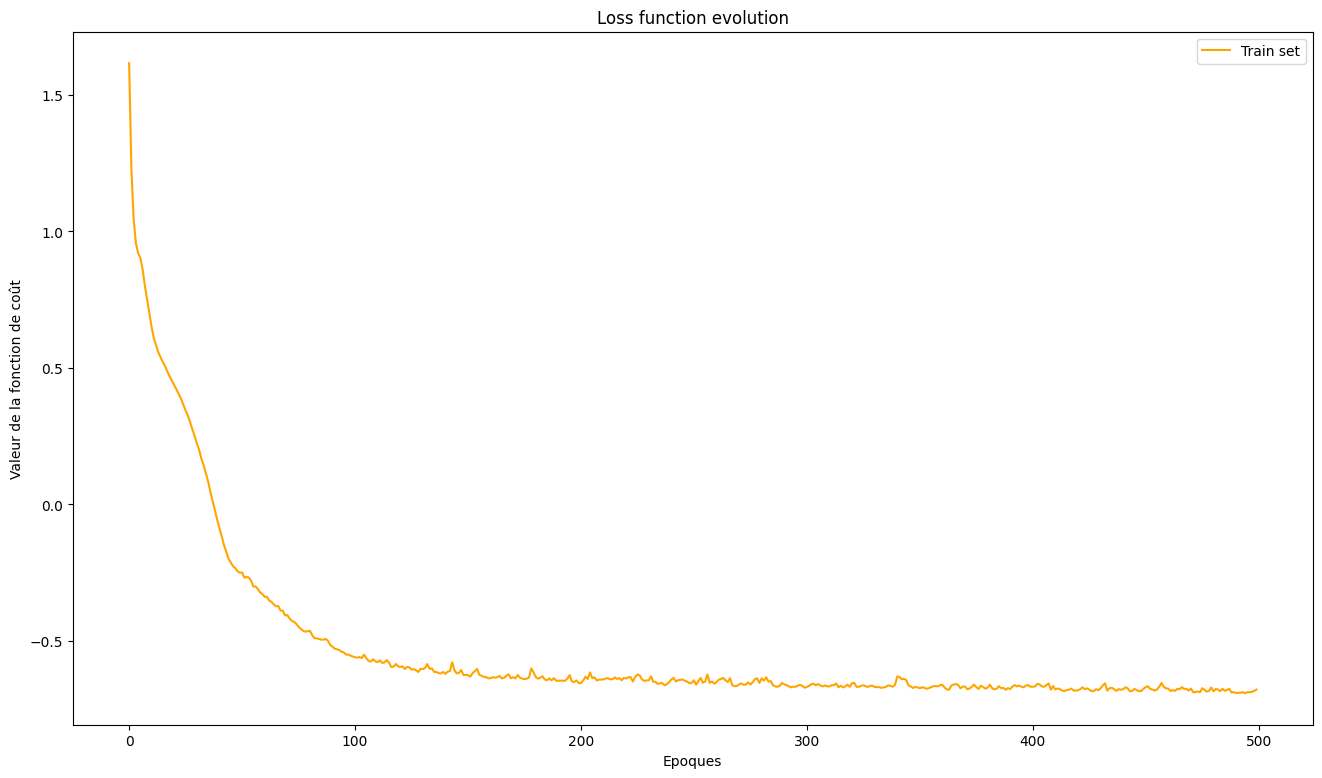

In [140]:
loss_evolution = learning.history["loss"]

plt.figure(figsize = (16,9))
plt.plot(loss_evolution,label = "Train set", color='orange')
plt.xlabel("Epoques")
plt.ylabel("Valeur de la fonction de coût")
plt.legend()
plt.title("Loss function evolution")


## Predictions

**Exercice**: Run a prediction on X_test.

In [141]:
Y_pred_test = model.predict(X_test)


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


**Exercise**: Divide the prediction in two vectors mu and sigma.

In [142]:
mu = Y_pred_test[:,0]
sigma = Y_pred_test[:,1]

The following cell gives you a visualization of your prediction (mean) and the associated uncertainty. The grey areas correspond to uncertainty at 1, 2, 3 and 4 sigmas.

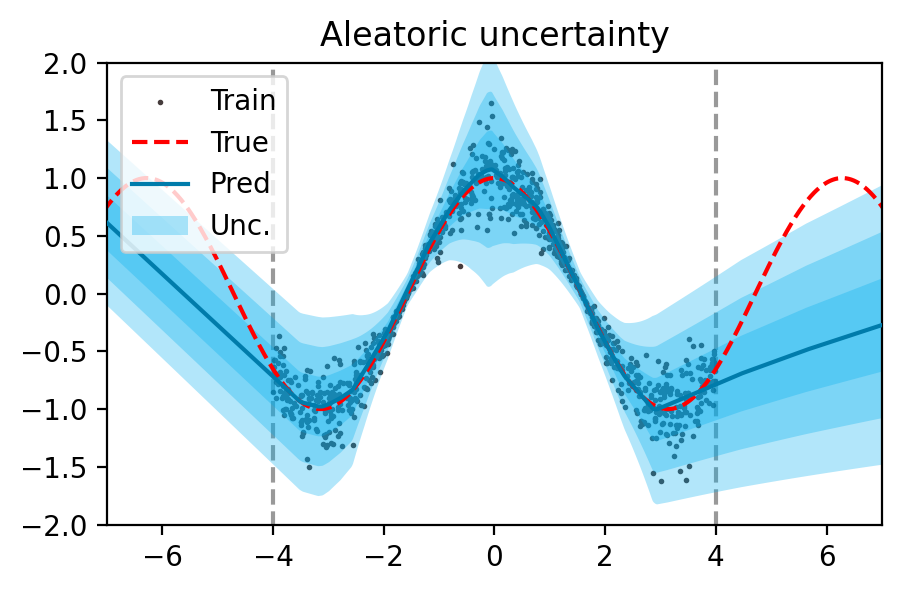

In [143]:
var = np.minimum(sigma, 1e3)
    
plt.figure(figsize=(5, 3), dpi=200)
plt.title("Aleatoric uncertainty")
plt.scatter(X_train, Y_train, s=1., c='#463c3c', zorder=0, label="Train")
plt.plot(X_test, Y_test, 'r--', zorder=2, label="True")
plt.plot(X_test, mu, color='#007cab', zorder=3, label="Pred")
plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
for k in np.linspace(0, 4, 4):
    plt.fill_between(
        X_test, (mu - k * var), (mu + k * var),
        alpha=0.3,
        edgecolor=None,
        facecolor='#00aeef',
        linewidth=0,
        zorder=1,
        label="Unc." if k == 0 else None)
plt.gca().set_ylim(-2, 2)
plt.gca().set_xlim(-7, 7)
plt.legend(loc="upper left")